The goal is for the model to take:

1) Time
2) Transmit Grid Square

Output:
1) Most likely Grid Squares to contact
2) Which band to use
3) Which Mode to use

Label is: db

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torchtext.transforms import LabelToIndex
from typing import List
import matplotlib.pyplot as plt
import os
from torch import nn


In [40]:
class DXDataset(Dataset):
    def __init__(self, file):
        self.data = pd.read_csv(file)

        # self.data = self.data.sample(frac=0.001)
        self.labels = self.data['callsign_grid'].unique()

        self.target_labels = {
            'dx_grid': self.data['dx_grid'].unique(),
            'band': self.data['band'].unique(),
            'mode': self.data['mode'].unique(),
            'tx_mode': self.data['tx_mode'].unique(),
        }

        self.transform = LabelToIndex(label_names=self.labels.tolist())
        self.target_transforms = {
            'dx_grid': LabelToIndex(label_names=self.target_labels['dx_grid'].tolist()),
            'band': LabelToIndex(label_names=self.target_labels['band'].tolist()),
            'mode': LabelToIndex(label_names=self.target_labels['mode'].tolist()),
            'tx_mode': LabelToIndex(label_names=self.target_labels['tx_mode'].tolist()),
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx].drop(["Unnamed: 0", "snr",'dx_grid','band','mode', 'tx_mode'])
        label = self.data.iloc[idx]

        data['callsign_grid'] = self.transform.forward(data['callsign_grid'])
        data = torch.FloatTensor(data)
        label = torch.FloatTensor([
            self.target_transforms['dx_grid'].forward(label['dx_grid']),
            self.target_transforms['band'].forward(label['band']),
            self.target_transforms['mode'].forward(label['mode']),
            self.target_transforms['tx_mode'].forward(label['tx_mode']),
        ])
        return data, label

In [41]:
training_data = DXDataset("data/train.csv")
test_data = DXDataset("data/test.csv")
print(len(training_data), len(test_data))

285077 71723


In [42]:

data, label = training_data.__getitem__(300)
label

tensor([44.,  2.,  0.,  0.])

In [43]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [44]:
train_features, train_labels = next(iter(train_dataloader))
train_features

tensor([[ 60.,  -1.,  -1.,  ...,   2.,  35.,  56.],
        [130.,  -1.,  -1.,  ...,  11.,  50.,  26.],
        [  9.,  -1.,  -1.,  ...,  11.,  28.,  35.],
        ...,
        [ 11.,  -1.,  -1.,  ...,   9.,  27.,  52.],
        [ 57.,  -1.,  -1.,  ...,   2.,  33.,  42.],
        [ 41.,  -1.,  -1.,  ...,   9.,  26.,  12.]])

Feature batch shape: torch.Size([64, 51])
Labels batch shape: torch.Size([64, 4])


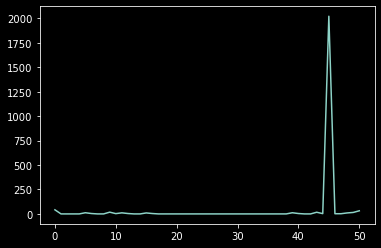

Label: tensor([1087.,    3.,    0.,    0.])


In [45]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input = train_features[0]
label = train_labels[0]
plt.plot(input)
plt.show()
print(f"Label: {label}")

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(training_data.__getitem__(0)[0]), 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(training_data.__getitem__(0)[1])),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [48]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [49]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            item_check = (pred.argmax(dim=0) == y)

            correct += (pred.argmax(dim=0) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= (size * y.numel() 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 20129.039062  [    0/285077]
loss: 527609.187500  [ 6400/285077]
loss: 244442.953125  [12800/285077]
loss: 55528.382812  [19200/285077]
loss: 157270.484375  [25600/285077]
loss: 43845.664062  [32000/285077]
loss: 230290.109375  [38400/285077]
loss: 101550.296875  [44800/285077]
loss: 46639.453125  [51200/285077]
loss: 145.615952  [57600/285077]
loss: 23.554371  [64000/285077]
loss: 22.658058  [70400/285077]
loss: 21.969233  [76800/285077]
loss: 19.049816  [83200/285077]
loss: 20.043266  [89600/285077]
loss: 19.719313  [96000/285077]
loss: 17.962652  [102400/285077]
loss: 19.513931  [108800/285077]
loss: 18.459335  [115200/285077]
loss: 19.323519  [121600/285077]
loss: 14.575040  [128000/285077]
loss: 17.032549  [134400/285077]
loss: 16.449919  [140800/285077]
loss: 18.817337  [147200/285077]
loss: 17.731905  [153600/285077]
loss: 18.923172  [160000/285077]
loss: 18.029598  [166400/285077]
loss: 19.056351  [172800/285077]
loss: 16.909197  [1

In [53]:
test_loop(test_dataloader, model, loss_fn)
